# Fip35 WW domain: MSM and hdbMSM

### In this notebook we show the essentials to obtain the MSM and hdbMSM corresponding to a previously run simulation of the Fip35 WW domain from the Shaw group.

In [1]:
import mdtraj as md

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

### Analysis

In [5]:
traj = md.load_dcd("data/ww_join.dcd", \
                   top="data/ww_1-10.pdb")

In [6]:
import pyemma
pyemma.__version__

'2.5.7'

In [7]:
import pyemma.coordinates as coor

In [8]:
topfile = "data/ww_1-10.pdb"
feat = coor.featurizer(topfile)

In [9]:
feat.add_distances_ca()

In [10]:
feat.describe()[:10]

['DIST: GLY 1 CA 4 0 - LEU 4 CA 44 0',
 'DIST: GLY 1 CA 4 0 - PRO 5 CA 65 0',
 'DIST: GLY 1 CA 4 0 - PRO 6 CA 79 0',
 'DIST: GLY 1 CA 4 0 - GLY 7 CA 91 0',
 'DIST: GLY 1 CA 4 0 - TRP 8 CA 98 0',
 'DIST: GLY 1 CA 4 0 - GLU 9 CA 122 0',
 'DIST: GLY 1 CA 4 0 - LYS 10 CA 137 0',
 'DIST: GLY 1 CA 4 0 - ARG 11 CA 159 0',
 'DIST: GLY 1 CA 4 0 - MET 12 CA 183 0',
 'DIST: GLY 1 CA 4 0 - SER 13 CA 200 0']

In [12]:
inp = coor.source(["data/ww_join.dcd", "data/ww_join_2.dcd"], feat)

In [13]:
print ('number of trajectories = ', inp.ntraj)
print('trajectory length = ',inp.trajectory_length(0))
print('number of dimension = ',inp.dimension())

number of trajectories =  2
trajectory length =  5000
number of dimension =  528


We carry out dimensionality reduction by using TICA with three dimensions and 400 ns lag time, since it is calculated as a multiple of the time step between frames, that is 20 ns.

In [14]:
lag=20
tica_obj = coor.tica(inp, lag=lag, dim=3, kinetic_map=False)

In [15]:
Y0 = tica_obj.get_output()[0]
print('Projected data shape = ', Y0.shape)

Y1 = tica_obj.get_output()[1]
print('Projected data shape = ', Y1.shape)

Ycum = np.vstack([Y0, Y1])
Ycum.shape

Projected data shape =  (5000, 3)
Projected data shape =  (5000, 3)


(10000, 3)

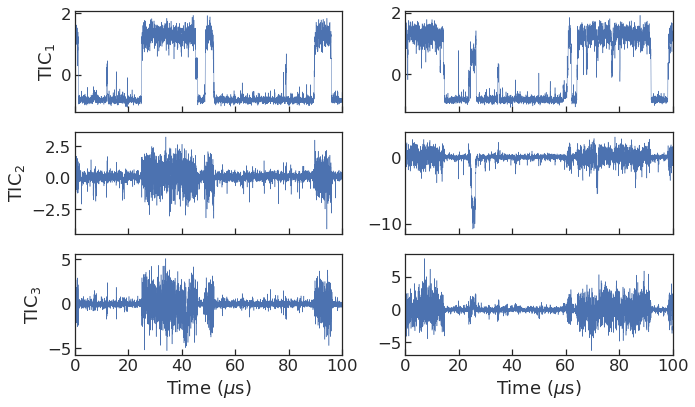

In [19]:
# Note the time step is 20 ns, and each trajectory is 5000 ns long
xaxis = np.arange(0,5e3,1)
xaxis = xaxis*0.02
fig, ax = plt.subplots(3,2, figsize=(10,6), sharex=True)
for i in range(3):
    ax[i][0].plot(xaxis, Y0[:,i], lw=0.5)
    ax[i][0].set_ylabel('TIC$_%g$'%(i+1))
ax[-1][0].set_xlabel('Time')

for i in range(3):
    ax[i][1].plot(xaxis, Y1[:,i], lw=0.5)
    #ax[i][1].set_ylabel('TIC$_%g$'%(i+1))
ax[-1][1].set_xlabel('Time ($\mu$s)')
ax[-1][0].set_xlabel('Time ($\mu$s)')
ax[-1][0].set_xlim(0,1e2)
plt.tight_layout()
plt.savefig('../figures/fip35_ww/tica.png', dpi=300, transparent=True)

### Traditional MSM construction

First, let's do K-means clustering with 200 cluster centers and data resulting from first two components of TICA, which retrieve most of relevant data as shown in plots above. Therefore, hereafter the feature space is wherein look at the clusters is composed of $TIC_{1}$ and $TIC_{2}$.

In [20]:
cl = coor.cluster_kmeans(data=[Y0, Y1], k=200, max_iter=100)
# for later use we save the discrete trajectories and cluster center coordinates:
dtrajs = cl.dtrajs
cc_x = cl.clustercenters[:,0]
cc_y = cl.clustercenters[:,1]

/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


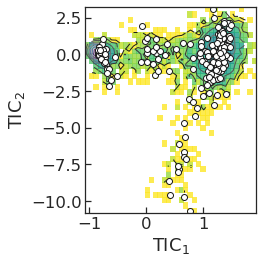

In [21]:
fig, ax = plt.subplots(figsize=(4,4))
# histogram data
counts, ybins, xbins, image = ax.hist2d(Ycum[:,0],Ycum[:,1], \
                bins=[40,40], \
                cmap='viridis_r', \
                norm=mpl.colors.LogNorm(), density=True, alpha=0.8)
ax.contour(np.transpose(np.log(counts)), extent=[ybins.min(), ybins.max(), \
                                         xbins.min(), xbins.max()], \
                  linewidths=1, cmap=cm.binary_r, \
           levels = np.arange(-6,4,1))

plt.plot(cc_x,cc_y, linewidth=0, marker='o', mfc='w', mec='k')

ax.set_xlabel('TIC$_1$')
ax.set_ylabel('TIC$_2$')
plt.tight_layout()
plt.savefig('../figures/fip35_ww/kmeans.png', dpi=300, transparent=True)

In [22]:
import pyemma.msm as msm
import pyemma.plots as mplt

lags = range(1,50,5)

its = msm.its(dtrajs, lags=lags, errors='bayes')

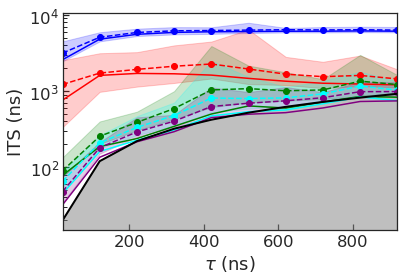

In [23]:
mplt.plot_implied_timescales(its, show_mean=True,nits=5, units='ns', dt=20)
plt.ylabel('ITS (ns)')
plt.xlabel(r'$\tau$ (ns)')
plt.savefig('../figures/fip35_ww/kmeans_its.png', dpi=300, transparent=True)

From the implied timescales, let us consider that the MSM is converged for a lag time of 400 ns. So estimate the corresponding MSM and corresponding relaxation times.

In [24]:
M = msm.bayesian_markov_model(dtrajs, 20, dt_traj='20 ns')

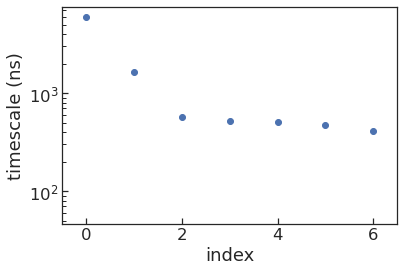

In [28]:
plt.plot(M.timescales(),linewidth=0,marker='o')
plt.xlabel('index')
plt.ylabel('timescale (ns)')
plt.xlim(-0.5,6.5)
plt.yscale('log')
plt.savefig('../figures/fip35_ww/kmeans_times.png', dpi=300, transparent=True)

Since we obtained two well-defined slow eigenmodes, we perform PCCA+ spectral clustering with three macrostates.

In [29]:
M.pcca(3)

PCCA(P=array([[2.22045e-16, 0.00000e+00, ..., 0.00000e+00, 0.00000e+00],
       [0.00000e+00, 8.15710e-02, ..., 1.42983e-03, 0.00000e+00],
       ...,
       [0.00000e+00, 4.66949e-02, ..., 4.44089e-16, 0.00000e+00],
       [0.00000e+00, 0.00000e+00, ..., 0.00000e+00, 6.66134e-16]]),
   m=3)

In [30]:
pcca_sets = M.metastable_sets

/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


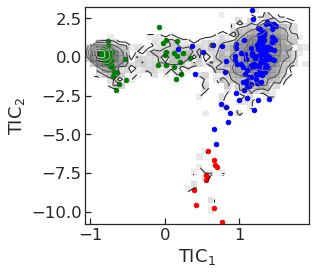

In [31]:
fig, ax = plt.subplots(figsize=(4,4))
# histogram data
counts, ybins, xbins, image = ax.hist2d(Ycum[:,0],Ycum[:,1], \
                bins=[40,40], \
                cmap='binary', \
                norm=mpl.colors.LogNorm(), density=True, alpha=0.8)
ax.contour(np.transpose(np.log(counts)), extent=[ybins.min(), ybins.max(), \
                                         xbins.min(), xbins.max()], \
                  linewidths=1, cmap=cm.binary_r, \
           levels = np.arange(-6,4,1))
ax.scatter(cl.clustercenters[pcca_sets[0],0], cl.clustercenters[pcca_sets[0],1], color='red', s=20)
ax.scatter(cl.clustercenters[pcca_sets[1],0], cl.clustercenters[pcca_sets[1],1], color='blue', s=20)
ax.scatter(cl.clustercenters[pcca_sets[2],0], cl.clustercenters[pcca_sets[2],1], color='green', s=20)
ax.set_xlabel('TIC$_1$')
ax.set_ylabel('TIC$_2$')
plt.savefig('../figures/fip35_ww/pcca.png', dpi=300, transparent=True)

Validate the MSM obtained from PCCA+ by computing the Chapman-Kolmogorov test for the previously computed Bayesian MSM.

In [32]:
ck = M.cktest(3)

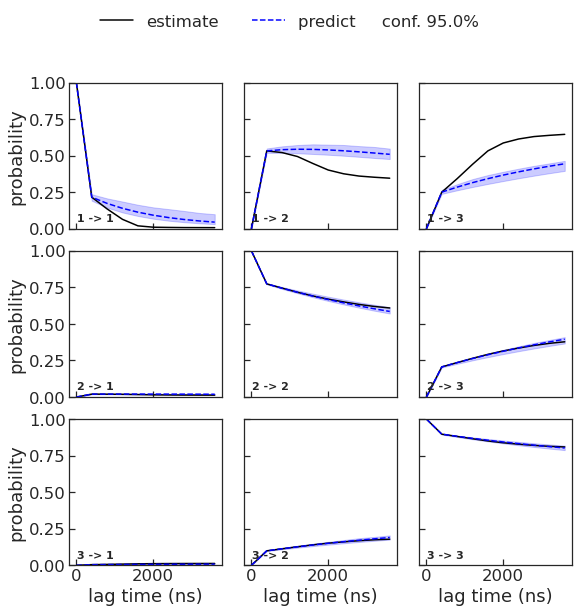

In [33]:
plt.rcParams.update({'font.size': 11})
fig, axes = mplt.plot_cktest(ck, figsize=(9, 9), padding_between=0.15, padding_top=0.13, units='ns', dt=20)
plt.savefig('../figures/fip35_ww/pcca_ck.png', dpi=300, transparent=True)

### MSM construction exploting density-based clustering

In [34]:
import hdbscan

In [35]:
np.shape(Ycum)

(10000, 3)

Apply HDBSCAN clustering to previously normalized data with 'minimum cluster size' and 'minimum samples' equal to 20 and 15, respectively. Then look into resulting clusters.

In [36]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(Ycum)

In [37]:
hdb = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=15).fit(X)

In [38]:
np.unique(hdb.labels_)

array([-1,  0,  1,  2,  3])

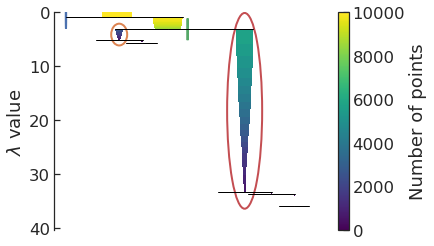

In [39]:
hdb.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.savefig('../figures/fip35_ww/hdbscan_tree.png', dpi=300, transparent=True)

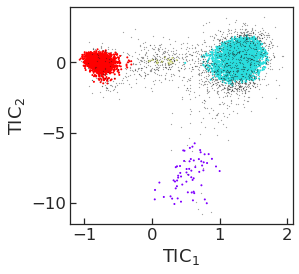

In [40]:
fig, ax = plt.subplots(figsize=(4,4))
# histogram data
assign = hdb.labels_ >= 0
ax.scatter(Ycum[assign,0],Ycum[assign,1], marker='o', 
                cmap='rainbow', s=1, c=hdb.labels_[assign])
nassign = hdb.labels_ == -1
ax.scatter(Ycum[nassign,0],Ycum[nassign,1], marker='.', 
                cmap='rainbow', s=0.1, c='k')
ax.set_xlabel('TIC$_1$')
ax.set_ylabel('TIC$_2$')
plt.savefig('../figures/fip35_ww/hdbscan.png', dpi=300, transparent=True)

Plot clusters projected onto TICA components along the trajectory to check if different regions are properly retrieved by HDBSCAN. Recall that label=-1 denotes 'noise', so the latter is always shown (plots above and below) as black small dots.

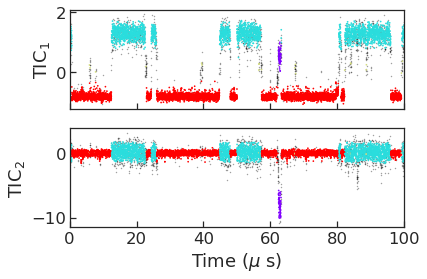

In [46]:
nxax = np.arange(len(Ycum[:,0]))[nassign]
nxax = nxax/100
axax = np.arange(len(Ycum[:,0]))[assign]
axax = axax/100
nxax2 = np.arange(len(Ycum[:,1]))[nassign]
nxax2 = nxax2/100
axax2 = np.arange(len(Ycum[:,1]))[assign]
axax2 = axax2/100
assign = hdb.labels_>= 0
nassign = hdb.labels_ < 0
fig, ax = plt.subplots(2,1, sharey=False, sharex=True)
ax[0].scatter(nxax, Ycum[nassign,0], s=0.15, c='k', alpha=0.5)
ax[0].scatter(axax, Ycum[assign,0], s=0.5, cmap=cm.rainbow
        , c=hdb.labels_[assign])
ax[1].scatter(nxax2, Ycum[nassign,1], s=0.15, c='k', alpha=0.5)
ax[1].scatter(axax2, Ycum[assign,1], s=0.5, cmap=cm.rainbow
        , c=hdb.labels_[assign])
ax[0].set_ylabel('TIC$_1$')
ax[1].set_ylabel('TIC$_2$')
ax[1].set_xlim(0,100)
ax[1].set_xlabel('Time ($\mu$ s)')
plt.savefig('../figures/fip35_ww/hdbscan_traj.png', dpi=300, transparent=True)

Exclude noise points from HDBSCAN clusters in order to estimate corresponding MSM.

In [47]:
def filter_labels(labels):
    x = []
    for l in labels:
        if l >= 0:
            x.append(l)
        else:
            try:
                x.append(x[-1])
            except IndexError:
                pass
    return x

In [48]:
dtrajs = [filter_labels(hdb.labels_[:5000]), filter_labels(hdb.labels_[5000:])]

In [49]:
lags = range(1,50,5)

its = msm.its(dtrajs, lags=lags, errors='bayes')

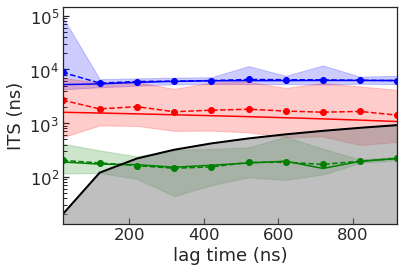

In [51]:
mplt.plot_implied_timescales(its, show_mean=True, units='ns', dt=20)
plt.ylabel('ITS (ns)')
plt.xlabel('lag time (ns)')
plt.savefig('../figures/fip35_ww/hdbscan_its.png', dpi=300, transparent=True)

For comparison, let us choose the same lag time as done above for traditional MSM construction procedure.

In [52]:
M = msm.bayesian_markov_model(dtrajs, 20, dt_traj='20 ns')

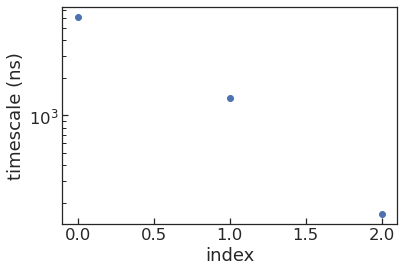

In [54]:
plt.plot(M.timescales(),linewidth=0,marker='o')
plt.xlabel('index')
plt.ylabel('timescale (ns)')
plt.yscale('log')
plt.savefig('../figures/fip35_ww/hdbscan_times.png', dpi=300, transparent=True)

In [55]:
ck_hdb = M.cktest(4)

/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/pyemma/util/statistics.py:59: UserWarning: confidence interval for constant data is not meaningful
  warnings.warn('confidence interval for constant data is not meaningful')


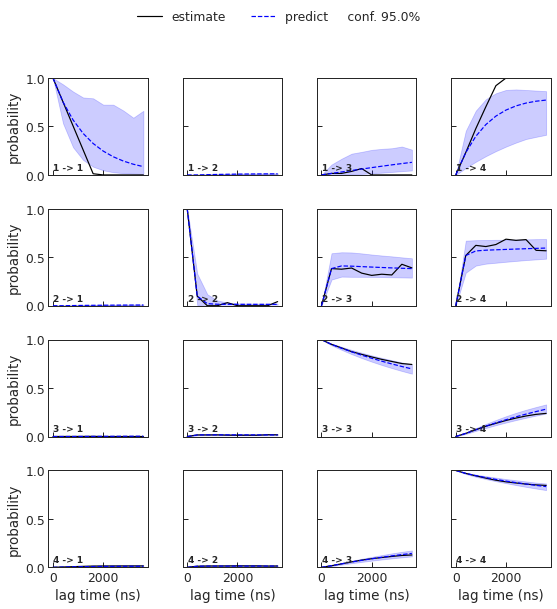

In [56]:
sns.set_context('paper', font_scale=1.4)
plt.rcParams.update({'font.size': 9})
fig, axes = mplt.plot_cktest(ck_hdb, figsize=(9, 9), padding_between=0.35, padding_top=0.12, units='ns', dt=20)
plt.savefig('../figures/fip35_ww/hdbscan_ck.png', dpi=300, transparent=True)